In [1]:
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

font = 20
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': font,
    'axes.labelsize': font,  
    'xtick.labelsize': font,  
    'ytick.labelsize': font, 
    'legend.fontsize': font,
    'legend.title_fontsize': font
})

# solve setup for two users and one server as defined in Vardoyan et al., 2023

beta = 0.2 # attenuation in fiber
c_loss = 1 # other system losses

attempt_durations_l = [10 ** -3, 10 ** -3] # [s]

def Fidel(w):
    return (3*w+1)/4 

def D_H(w1,w2):
    F = Fidel(w1*w2)
    return 1 + F*np.log2(F) + (1-F) * np.log2((1-F)/3) if F > 0.81 else 1e-10 # yield of the so-called “hashing” protocol

def U_D(R, w1, w2): 
    val = np.log(R*D_H(w1,w2))
    return val

def Objective(x):
    R, w1, w2 = x
    return - 2*U_D(R, w1, w2) + (2*R - d_l[0]*(1-w1))**2 + (R - d_l[1]*(1-w2))**2 

res = {'Distance [km]':[], 'Server link':[], 'User link':[], 'Utility':[], 'Rate':[], 'Fidelity':[]}
for i in [1.5**k for k in np.linspace(1,11.5,15)]:
    distances_l = [i, 2] # [km]

    eta_l = 10 ** (-0.1 * beta * np.array(distances_l)/2) # transmissivity between one link end and midpoint station
    d_l = 3 * c_loss * eta_l / (2*np.array(attempt_durations_l))

    sol = minimize(Objective, x0=(75, 0.95, 0.95), bounds=( (1,80), (0.85,1.), (0.85,1.)), method='L-BFGS-B')
    rate, ws, wu = sol.x
    U = U_D(rate, ws, wu)

    res['Server link'].append(Fidel(ws))
    res['User link'].append(Fidel(wu))
    res['Utility'].append(2*U) # aggregated utility
    res['Fidelity'].append(Fidel(ws*wu))
    res['Rate'].append(rate) 
    res['Distance [km]'].append(i) 
df_res = pd.DataFrame.from_records(res)


In [2]:
df_plot = df_res.melt(id_vars=['Distance [km]', 'Fidelity', 'Rate', 'Utility'], var_name='Type', value_name='Link Fidelity')

Text(0, 0.5, 'Fidelity')

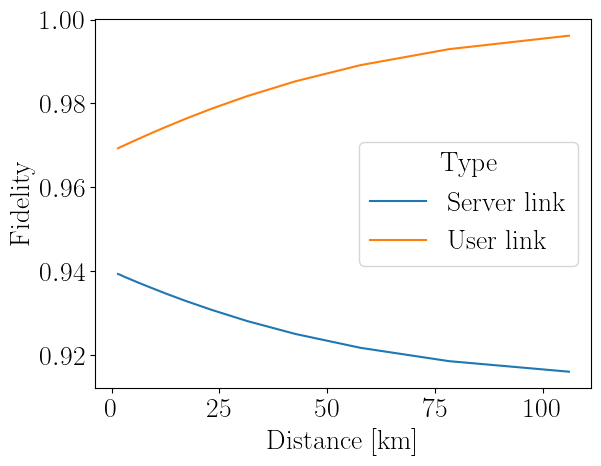

In [3]:
sns.lineplot(data=df_plot, x='Distance [km]', y='Link Fidelity', hue='Type', markers=True)
plt.ylabel('Fidelity')

<Axes: xlabel='Distance [km]', ylabel='Utility'>

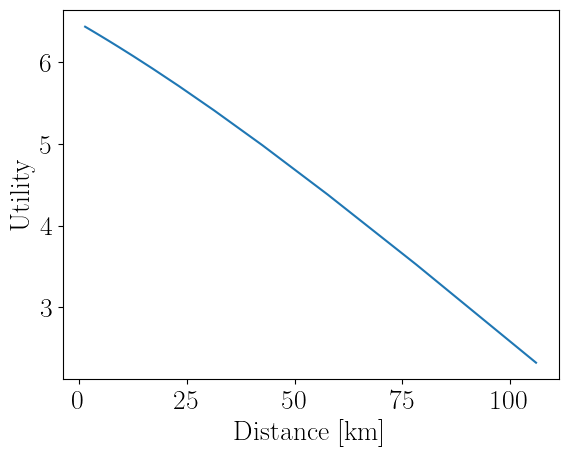

In [4]:
sns.lineplot(data=df_res, x='Distance [km]', y='Utility', markers=True)

(0.7, 1.0)

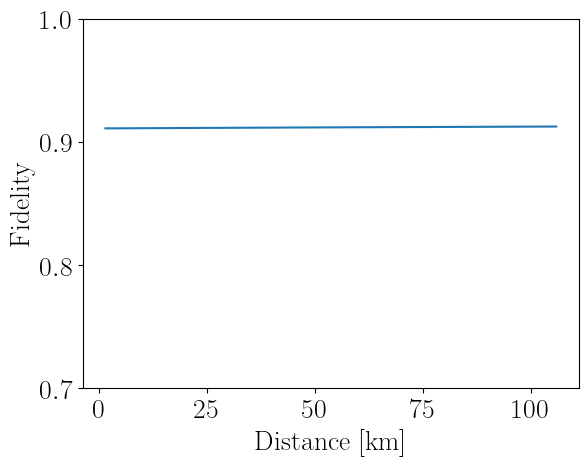

In [5]:
sns.lineplot(data=df_res, x='Distance [km]', y='Fidelity', markers=True)
plt.ylim([0.7,1])

<Axes: xlabel='Distance [km]', ylabel='Rate'>

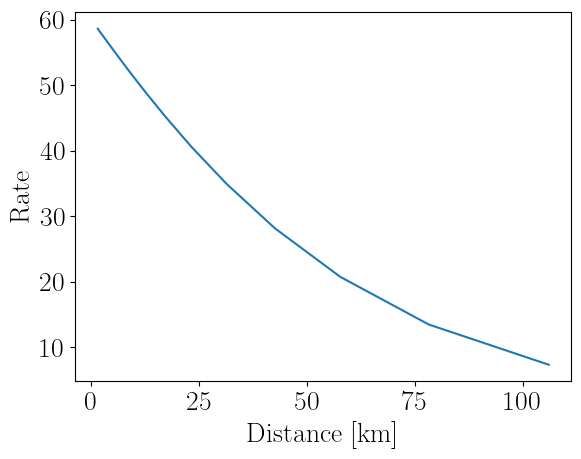

In [6]:
sns.lineplot(data=df_res, x='Distance [km]', y='Rate', markers=True)

In [53]:
conv = lambda x :np.fromstring(x.strip("[]"), sep=' ')
df = pd.read_csv('examples/Sur_df_qswitch_nleafnodes3_0.100h_bottleneck-link_SEED42_03-18-2024_19:34:34.csv', converters={'Fidelity': conv, 'Fidelity_std': conv, 'Rate': conv, 'Rate_std': conv})

In [54]:
df['Rate_std_actual'] = df['Rate_std'].apply(lambda x: np.sqrt(np.sum(np.square(x[1:]))) )
df['Fidelity_std_actual'] = df['Fidelity_std'].apply(lambda x: np.sqrt(np.sum(np.square(x[1:]))) )
df

,Unnamed: 0,bright_state_server,bright_state_user,Iteration,Fidelity,Fidelity_std,Rate,Rate_std,Utility,Utility_std,server_distance,Rate_std_actual,Fidelity_std_actual
0,0,0.066962,0.037356,10,"[0.8990175, 0.8990175, 0.8990175]","[2.10033169e-16, 1.93975744e-16, 2.02163945e-16]","[130.15, 65.42, 64.73]","[4.07450352, 2.41565072, 3.46062057]",6.348931,0.063176,1.500000,4.220339,2.801729e-16
1,1,0.066067,0.028526,7,"[0.90791946, 0.90791946, 0.90791946]","[1.83668678e-16, 9.53009977e-17, 9.86459044e-17]","[99.65, 50.06, 49.59]","[3.93947632, 2.30157841, 2.8767489]",6.034526,0.073995,12.444444,3.684148,1.371616e-16
2,2,0.064546,0.020876,17,"[0.91637521, 0.91637521, 0.91637521]","[2.42970823e-16, 1.97291809e-16, 9.86459044e-17]","[75.02, 37.58, 37.44]","[2.99466192, 2.30870207, 2.2305062]",5.660379,0.085792,23.388889,3.210181,2.205789e-16
3,3,0.075699,0.019666,13,"[0.90661973, 0.90661973, 0.90661973]","[6.73879817e-17, 1.27351315e-16, 1.68950611e-16]","[68.89, 34.25, 34.64]","[3.54250878, 2.89309523, 2.56994778]",5.261786,0.111338,34.333333,3.869707,2.115719e-16
4,4,0.066431,0.015231,0,"[0.91968654, 0.91968654, 0.91968654]","[8.05440437e-17, 1.2215109e-16, 1.19466123e-16]","[46.64, 23.6, 23.04]","[2.39174017, 1.75679133, 1.62428932]",4.780857,0.104557,45.277778,2.392620,1.708597e-16
5,5,0.082473,0.013677,21,"[0.90535364, 0.90535364, 0.90535364]","[6.2389148e-17, 1.41812423e-16, 1.67019684e-16]","[45.67, 23.26, 22.41]","[1.8044098, 1.84573477, 1.77642456]",4.408599,0.113019,56.222222,2.561722,2.191035e-16
6,6,0.074083,0.010994,6,"[0.91600822, 0.91600822, 0.91600822]","[2.5470263e-17, 5.69532395e-17, 4.41157896e-17]","[31.58, 15.51, 16.07]","[2.08846456, 1.6071878, 1.59377077]",3.915112,0.143830,67.166667,2.263439,7.204078e-17
7,7,0.074309,0.007946,7,"[0.91853229, 0.91853229, 0.91853229]","[2.24947272e-16, 2.83624845e-16, 1.70859718e-16]","[25.79, 13.11, 12.68]","[2.09105866, 1.60456585, 1.33676751]",3.563241,0.162271,78.111111,2.088439,3.311134e-16
8,8,0.073222,0.009654,34,"[0.91806667, 0.91806667, 0.91806667]","[1.01881052e-16, 1.57009246e-16, 1.78291841e-16]","[20.22, 9.34, 10.88]","[2.12642522, 1.92829349, 1.37710604]",3.045002,0.246456,89.055556,2.369544,2.375708e-16
9,9,0.079308,0.005401,6,"[0.91586279, 0.91586279, 0.91586279]","[1.95640802e-16, 2.13099509e-16, 2.26384649e-16]","[16.69, 7.97, 8.72]","[1.90121845, 1.21616308, 1.1133638]",2.624627,0.207906,100.000000,1.648827,3.109042e-16


Text(0.5, 0, 'Distance [km]')

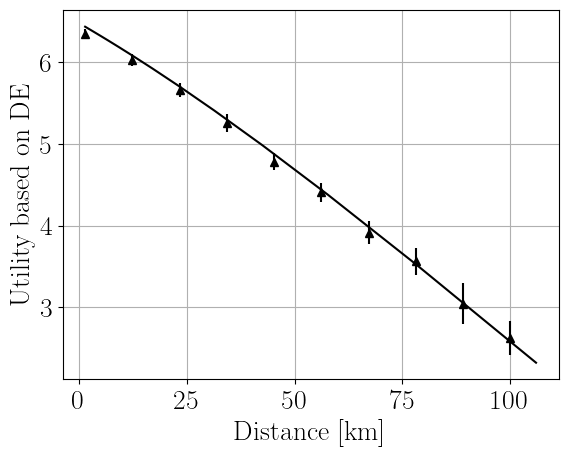

In [55]:
plt.errorbar(df['server_distance'], df['Utility'],df['Utility_std'], fmt='^', color='black')
sns.lineplot(data=df_res, x='Distance [km]', y='Utility', markers=True, color='black')
plt.grid()
plt.ylabel('Utility based on DE')
plt.xlabel('Distance [km]')

Text(0, 0.5, 'Fidelity')

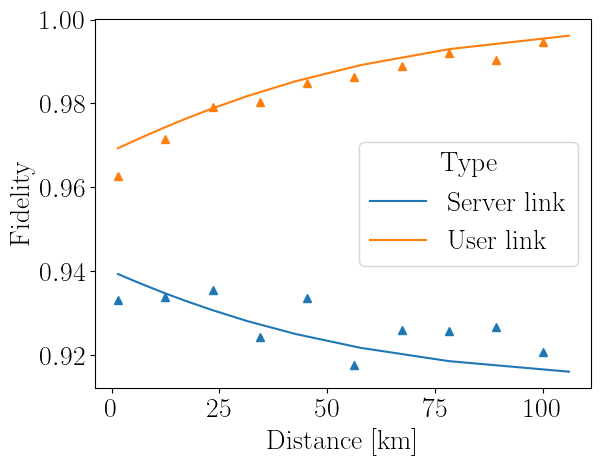

In [56]:
plt.plot(df['server_distance'], 1-df['bright_state_server'], '^')
plt.plot(df['server_distance'], 1-df['bright_state_user'], '^')
sns.lineplot(data=df_plot, x='Distance [km]', y='Link Fidelity', hue='Type', markers=True)
plt.ylabel('Fidelity')
plt.xlabel('Distance [km]')
plt.ylabel('Fidelity')

In [57]:
df['Rate_actual'] = df.Rate.apply (lambda x: sum(x[1:])/2)
df['Fidelity_actual'] = df.Fidelity.apply (lambda x: sum(x[1:])/2)

Text(0, 0.5, 'Rate [Hz]')

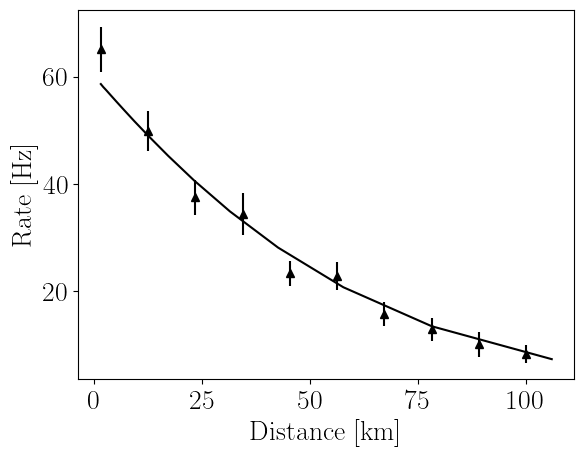

In [58]:
fig, ax1 = plt.subplots()
plt.errorbar(df['server_distance'], df['Rate_actual'], df['Rate_std_actual'], fmt='^' , color='black')
sns.lineplot(data=df_res, x='Distance [km]', y='Rate', markers=True, color='black', ax=ax1)
plt.xlabel('Distance [km]')
plt.ylabel('Rate [Hz]')

(0.7, 1.0)

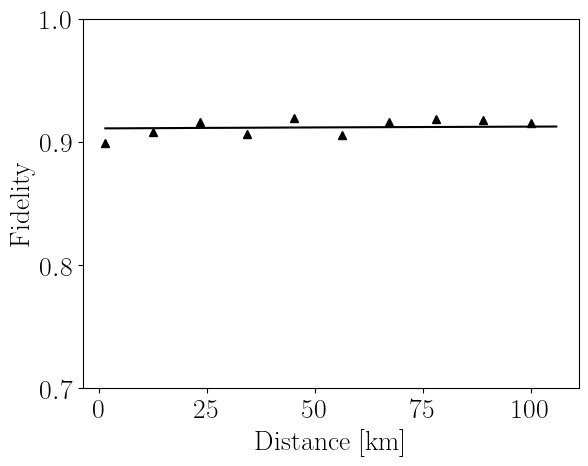

In [59]:
sns.lineplot(data=df_res, x='Distance [km]', y='Fidelity', markers=True, color='black')
plt.errorbar(df['server_distance'], df['Fidelity_actual'], df['Fidelity_std_actual'], fmt= '^', color='black' )
plt.ylim([0.7,1])

Werner states vs how we model depolarization in the simulation
$$\rho_{B00} = |\Psi^+><\Psi^+|$$
$$ \rho_w  = w \rho_{B00} + (1-w) \frac{I_4}{4}$$

$$\rho_{depol} = (1-\frac{3}{4}p)I\rho_{B00}I + \frac{p}{4}(X\rho_{B00}X + Y\rho_{B00}Y + Z\rho_{B00}Z)$$ 
$$\rho_{depol} = (1-\frac{3}{4}p + \frac{1}{4}p - \frac{1}{4}p)I\rho_{B00}I + \frac{p}{4}(X\rho_{B00}X + Y\rho_{B00}Y + Z\rho_{B00}Z)$$
$$\rho_{depol} = (1-p)I\rho_{B00}I + \frac{p}{4}(I\rho_{B00}I + X\rho_{B00}X + Y\rho_{B00}Y + Z\rho_{B00}Z)$$
$$\rho_{depol} = (1-p)\rho_{B00} + \frac{p}{4}I$$
$$\rightarrow w = 1-p$$

Link-level Fidelity
$$F = \frac{3w+1}{4} = 1-\alpha$$
$$\rightarrow w = 1 - \frac{4}{3}\alpha $$
$$\rightarrow p = 4/3\alpha $$